In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
#import h2o
#from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap


In [3]:
df_main_1 = pd.read_csv('D:/OneDrive - Diacto Technologies Private Limited/Documents/DS/Regression/Datasets/train _house.csv')


In [4]:
df_main_1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
df_main_copy = df_main_1.copy()

In [6]:

for col in df_main_1.columns:
    if df_main_1[col].dtype == object:
        try:
            df_main_1[col] = pd.to_numeric(df_main_1[col])
        except ValueError:
            try:
                df_main_1[col] = pd.to_datetime(df_main_1[col])
            except ValueError:
                pass
def null_handling(df_main, null_method = None, columns_name = None,):
  if null_method == 'Deletion':
    df_main = df_main.drop(columns = columns_name)

  elif null_method == 'Mean Imputing':
    imputer = SimpleImputer(strategy='mean')
    df_main = imputer.fit_transform(df_main[columns_name])

  elif null_method == 'Mode Imputing':
    imputer = SimpleImputer(strategy='most_frequent')
    df_main = imputer.fit_transform(df_main[columns_name])

  elif null_method == 'Median Imputing' :
    imputer = SimpleImputer(strategy='median')
    df_main = imputer.fit_transform(df_main[columns_name])

  else:
    df_main = df_main.copy()

  return df_main

def encoding(df_main, encoding_method = None, categorical_columns = None):
  #categorical_columns = df_main.select_dtypes(include=['object']).columns.tolist()
  if encoding_method == 'Delete':
    df = df_main.drop(columns = categorical_columns)

  elif encoding_method == 'Label Encoding':
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    label_encoder = LabelEncoder()
    for column in categorical_columns:
      df_main_copy[column] = label_encoder.fit_transform(df_main_copy[column])
    #df = df_main_copy.drop(columns=categorical_columns)
    df = df_main_copy

  elif encoding_method == 'Create Dummies':
    print('#################')
    dummy_df = pd.get_dummies(df_main[categorical_columns], drop_first=True)
    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df_main.drop(columns=categorical_columns), dummy_df], axis=1)

  else:
    df = df_main.copy()

  return df

numerical_columns = df_main_1.select_dtypes(include = ['int64','float64']).columns.tolist()
df_main_num = null_handling(df_main_1,'Mean Imputing', numerical_columns)
df_main_num = pd.DataFrame(df_main_num, columns=numerical_columns)  # Convert to DataFrame


categorical_columns_null = df_main_1.select_dtypes(include = ['object']).columns.tolist()
df_main_cat = null_handling(df_main_1,'Mode Imputing', categorical_columns_null)
df_main_cat = pd.DataFrame(df_main_cat, columns=categorical_columns_null)  # Convert to DataFrame


df_main = pd.concat([df_main_num, df_main_cat], axis=1)

categorical_columns = df_main.select_dtypes(include=['object']).columns.tolist()
df = encoding(df_main,'Create Dummies',categorical_columns )



#################


In [7]:
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
original_column_names = X_test.columns

In [10]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor(random_state = 42)
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 33068.99224734158


In [11]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = Ridge(alpha=100)
model.fit(X_train, y_train)

# model = RandomForestRegressor(random_state = 42)
# # Fits the model on the data
# model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 25668.1841000863


In [12]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = LinearRegression()
model.fit(X_train, y_train)

# model = RandomForestRegressor(random_state = 42)
# # Fits the model on the data
# model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 48856.908029969905


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# from sklearn.linear_model import LogisticRegression, RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [14]:
pipelines = {
    'lr' : make_pipeline(StandardScaler(), LinearRegression()),
    'rd' : make_pipeline(StandardScaler(), Ridge(alpha = 100)),
    'rf' : make_pipeline(StandardScaler(),  RandomForestRegressor(random_state = 42)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor()),
}

In [15]:
pipelines.keys()

dict_keys(['lr', 'rd', 'rf', 'gb'])

In [16]:
pipelines.values()

dict_values([Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=100))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])])

In [17]:
list(pipelines.values())[0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [18]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [19]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'rd': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridge', Ridge(alpha=100))]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestregressor',
                  RandomForestRegressor(random_state=42))]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingregressor', GradientBoostingRegressor())])}

In [20]:
from sklearn.metrics import accuracy_score # Accuracy metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle #saving model to disc

from sklearn.linear_model import LinearRegression

In [21]:
# without standardscaler
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    print(algo)
    # print("Accuracy: ", accuracy_score(y_test, yhat))
    # print("Confusion matrix: \n", confusion_matrix(y_test, yhat))
    # print("Classification report: \n", classification_report(y_test, yhat))
    print("RMSE: ", rmse)

lr
RMSE:  15996773151490.37
rd
RMSE:  25014.11156045266
rf
RMSE:  25218.634794430654
gb
RMSE:  25116.725164956595


In [25]:
#with standard scaler
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    print(algo)
    # print("Accuracy: ", accuracy_score(y_test, yhat))
    # print("Confusion matrix: \n", confusion_matrix(y_test, yhat))
    # print("Classification report: \n", classification_report(y_test, yhat))
    print("RMSE: ", rmse)

lr
RMSE:  15996773151490.37
rd
RMSE:  25014.11156045266
rf
RMSE:  25218.634794430654
gb
RMSE:  25116.725164956595


In [27]:
final_model = fit_models['rf']
final_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [30]:
X_test_transformed = pipelines['rf'].named_steps['standardscaler'].fit_transform(X_test)

# Extract the underlying model from the pipeline
final_model_rf = pipelines['rf'].named_steps['randomforestregressor']

In [35]:
X_test_transformed

array([[-0.45357908,  0.0908489 ,  0.69398786, ..., -0.10188534,
        -2.25462488,  3.13286048],
       [-1.19159598,  0.0908489 ,  0.04107403, ..., -0.10188534,
         0.44353276, -0.31919711],
       [ 1.53376054, -0.86943627,  0.04358315, ..., -0.10188534,
         0.44353276, -0.31919711],
       ...,
       [ 0.50632525, -0.14922239, -0.46116738, ..., -0.10188534,
        -2.25462488, -0.31919711],
       [ 1.1285748 ,  1.53127664, -0.21004667, ..., -0.10188534,
        -2.25462488,  3.13286048],
       [ 0.09872768, -0.62936498, -1.46565019, ..., -0.10188534,
         0.44353276, -0.31919711]])

In [37]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=original_column_names)
X_test_transformed_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.453579,0.090849,0.693988,0.451086,0.737109,-0.581189,1.199216,1.138934,-0.622725,-1.051219,...,-0.058621,-0.058621,3.198557,0.0,-2.474258,0.0,0.0,-0.101885,-2.254625,3.132860
1,-1.191596,0.090849,0.041074,0.160233,-0.051301,-0.581189,0.811143,0.538990,-0.622725,0.651442,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
2,1.533761,-0.869436,0.043583,7.013288,-0.839710,-0.581189,-0.773488,-1.810789,-0.622725,-0.209427,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
3,0.848804,-0.869436,0.191746,-0.451718,-0.839710,1.186594,-0.482433,-1.460822,-0.622725,0.637134,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
4,-0.629642,-0.869436,0.041074,-0.386902,-0.839710,1.186594,-0.450094,-0.060953,-0.622725,-0.786519,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,-1.572664,-0.149222,0.794436,-0.243115,-0.839710,1.186594,-1.711331,0.938953,-0.622725,-1.051219,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
288,-0.390872,-0.869436,0.543315,0.425010,-0.839710,0.302702,0.164355,-0.460916,2.442174,2.008324,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,0.443533,-0.319197
289,0.506325,-0.149222,-0.461167,0.099590,-1.628119,-1.465080,-0.741148,-1.810789,-0.622725,-1.051219,...,-0.058621,-0.058621,-0.312641,0.0,0.404162,0.0,0.0,-0.101885,-2.254625,-0.319197
290,1.128575,1.531277,-0.210047,-0.203034,2.313927,-0.581189,1.166877,1.088939,4.492117,2.621187,...,-0.058621,-0.058621,3.198557,0.0,-2.474258,0.0,0.0,-0.101885,-2.254625,3.132860


In [39]:
explainer = shap.TreeExplainer(final_model_rf)
shap_values = explainer(X_test_transformed_df)

For regression models, shap_values represent the additive contributions of each feature to the predicted outcome. Positive SHAP values indicate that the feature is pushing the model's prediction higher, while negative values indicate the opposite.

For classification models, the shap_values provide an explanation of the class prediction. They represent the impact of each feature on the model's decision-making process. Higher SHAP values for a feature for a particular class suggest that the feature is more relevant in pushing the model towards predicting that class.

In essence, shap_values allow you to understand which features are most influential in making the model's predictions for individual data points. This information is crucial for interpreting the behavior of complex models and gaining insights into how specific features contribute to the overall predicti

Explanation of Outcome:
values: An array of SHAP values for each feature and each sample in the provided data. Each row corresponds to a sample, and each column corresponds to a feature.

base_values: A single value or an array of base values, representing the expected model output without considering any features. It's usually the average of the model outputs over the training data.

data: The data for which SHAP values were computed. Each row represents a sample, and each column represents a feature.ons.

In [33]:
shap_values

.values =
array([[ 1.86166371e+01,  7.46538438e+02,  7.10606952e+02, ...,
        -3.04837552e+00, -1.76917560e+01,  9.64365881e+01],
       [ 5.39675166e+00,  3.70986337e+02,  1.77099476e+02, ...,
        -2.63071854e-01,  4.57511013e+01, -9.94833366e+00],
       [ 8.48847935e+00, -4.19060534e+00,  4.94249436e+02, ...,
        -1.13351377e+01,  6.99771656e+01, -9.23007699e+00],
       ...,
       [-1.97704391e+02,  4.77888509e+02,  2.96757842e+02, ...,
        -2.57168548e+00, -3.26399460e+02, -7.20065228e+00],
       [ 1.05108291e+02, -5.54295840e+02,  8.52026828e+02, ...,
         1.23892863e+01, -3.90796123e+01,  2.46972689e+02],
       [-1.00819082e+02, -6.88770795e+00, -1.52086125e+03, ...,
        -6.32684042e+00,  7.49146738e+01, -9.91188034e+00]])

.base_values =
array([181844.4525, 181844.4525, 181844.4525, 181844.4525, 181844.4525,
       181844.4525, 181844.4525, 181844.4525, 181844.4525, 181844.4525,
       181844.4525, 181844.4525, 181844.4525, 181844.4525, 181844.4525,
 

In [58]:
# Extract the column names
feature_names = [f"Feature_{i}" for i in range(shap_values.values.shape[1])]

# Create a DataFrame with the shap_values and the extracted feature names
shap_values_df = pd.DataFrame(data=shap_values.values, columns=original_column_names)
shap_values_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.616637,746.538438,710.606952,3492.199305,14972.036055,-135.893223,2081.178332,3358.315633,-357.280393,-4339.916428,...,-0.719468,-5.903416,29.323297,0.150617,349.270614,-0.298490,-0.015144,-3.048376,-17.691756,96.436588
1,5.396752,370.986337,177.099476,1496.063651,-17698.675388,-182.091149,1589.790275,1924.214894,-491.960993,2241.464183,...,-0.871090,-0.515342,-24.009839,0.286005,-37.837645,-0.552222,0.820046,-0.263072,45.751101,-9.948334
2,8.488479,-4.190605,494.249436,9163.108032,-34037.486559,-1141.874538,-1460.838097,-2174.966215,-231.731148,-875.860631,...,-0.364290,-0.094286,-16.115956,0.091708,-21.110226,-0.599433,-1.014427,-11.335138,69.977166,-9.230077
3,69.258539,116.007701,331.233100,-3140.623482,-31457.522890,1780.091288,465.089767,-2544.401203,-318.194736,1995.977511,...,-0.463321,-0.216630,-28.922949,0.803519,-21.232827,-1.797245,0.073692,-2.016912,45.344049,-8.128218
4,-186.239305,-4.289810,270.646991,-1191.733523,-31499.073967,1685.189389,583.993866,1234.112671,-302.907907,-3547.914773,...,-0.486588,-0.251040,-22.568754,1.080729,-27.470247,-0.376291,0.929591,1.228226,52.207250,-4.010051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,146.074936,324.091830,384.226059,-948.164047,-32101.811524,2484.993375,-2742.133317,2460.949227,-271.941767,-5249.532795,...,-0.678655,-0.860547,-21.328004,-0.116207,-10.386672,-3.285005,1.275544,-2.678701,51.663690,-0.714281
288,-215.520058,320.988750,280.540241,3023.481579,-37906.352054,635.349582,1246.411648,-630.798569,910.482045,6948.110012,...,-0.385388,-0.163214,-24.087306,0.010991,-33.111490,-0.419041,-0.728230,-0.738216,58.420924,-18.080598
289,-197.704391,477.888509,296.757842,1455.777185,-40100.042371,-4632.401348,-2560.688111,-2013.047228,-253.165991,-3075.643242,...,-0.566367,-1.656264,-20.806185,0.219823,-25.229904,-4.756225,16.049874,-2.571685,-326.399460,-7.200652
290,105.108291,-554.295840,852.026828,-3868.669737,140974.093725,-127.724836,923.178554,1221.466469,178.504319,18877.710334,...,-0.371565,-0.209362,1133.271885,0.007902,835.836992,-0.171312,-0.438797,12.389286,-39.079612,246.972689


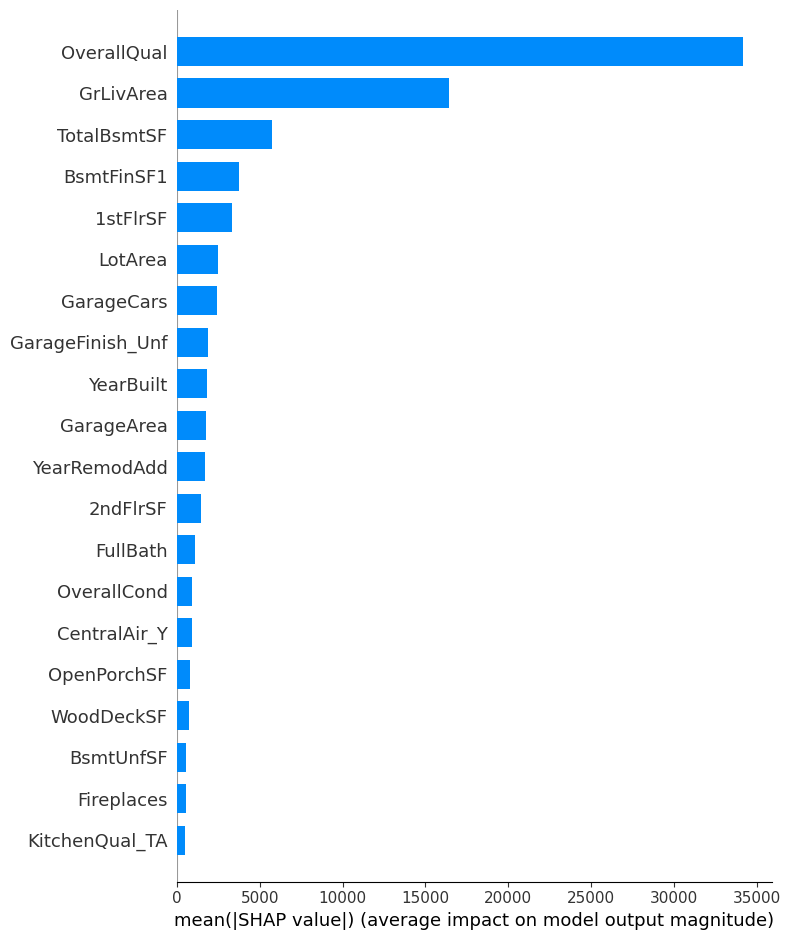

In [62]:
shap.summary_plot(shap_values_df, plot_type="bar", feature_names=original_column_names, show=False) 

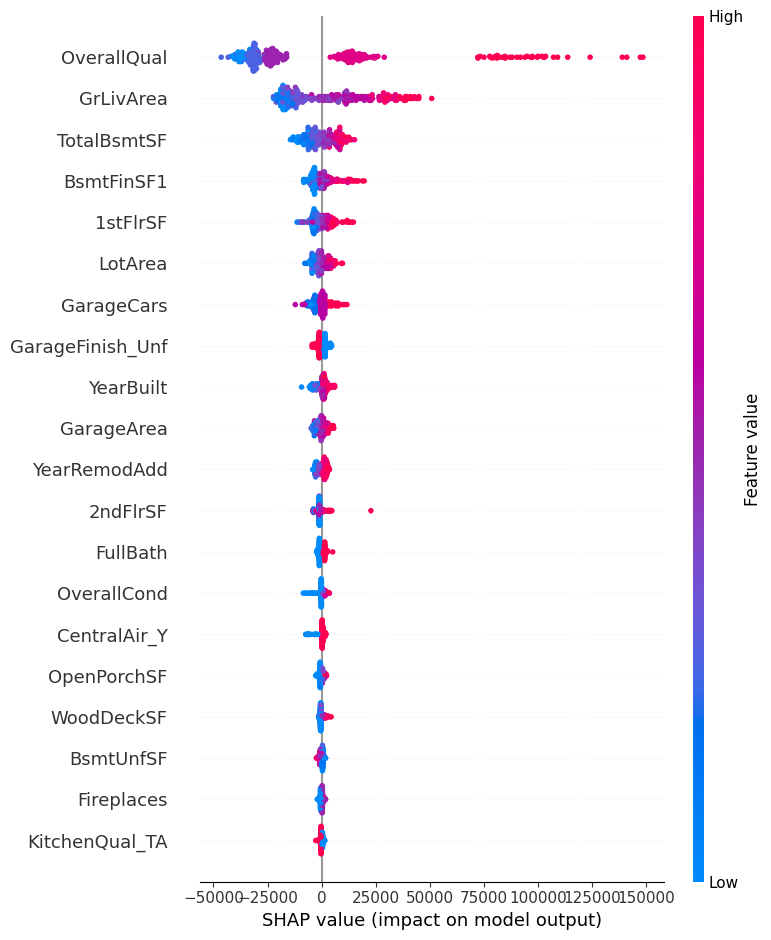

In [52]:
shap.summary_plot(shap_values.values, X_test_transformed_df)

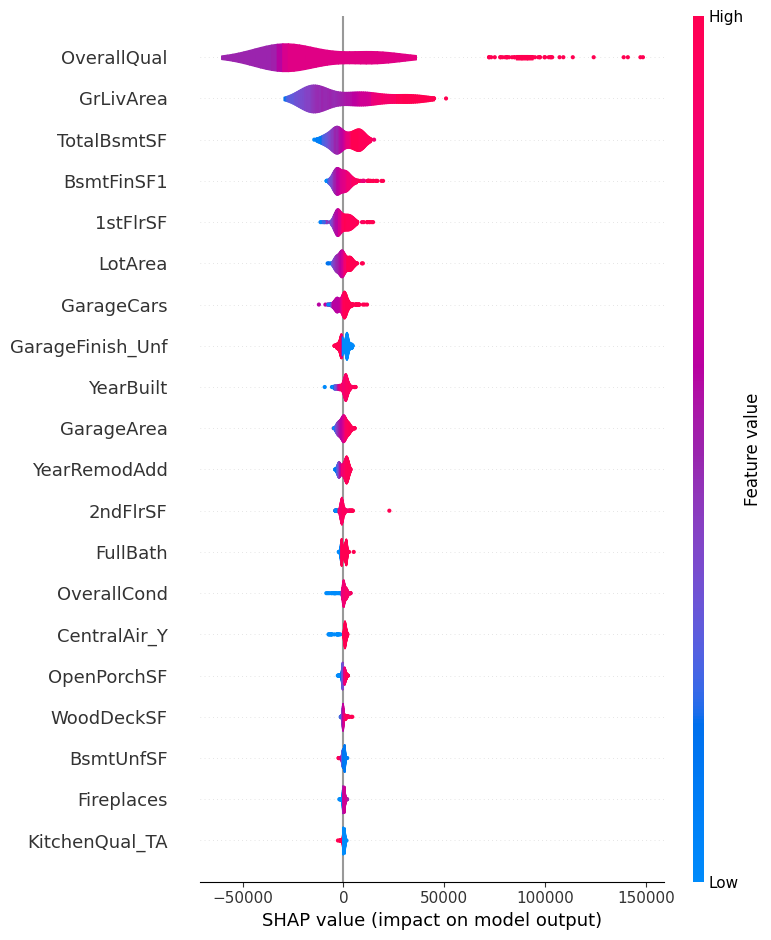

In [41]:
shap.summary_plot(shap_values, X_test_transformed_df,  plot_type='violin')

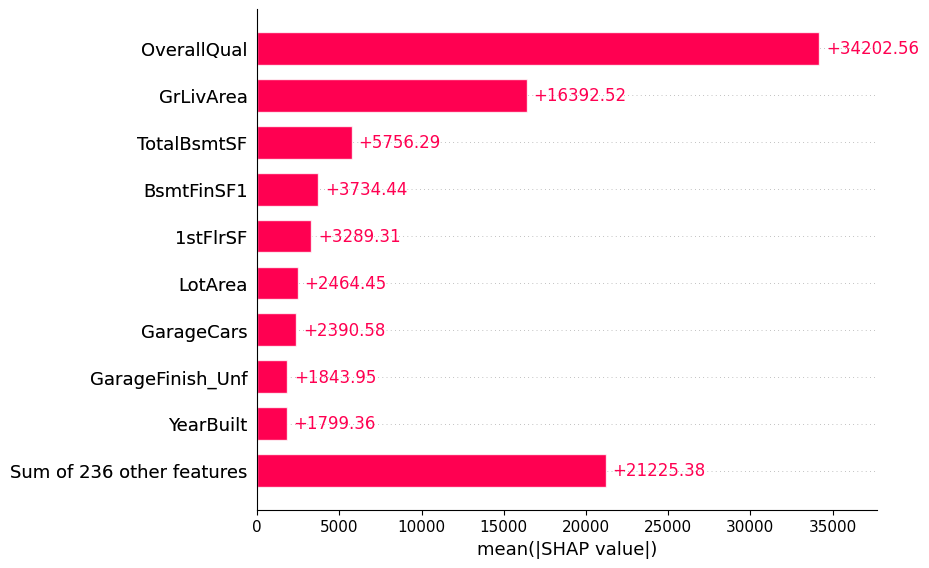

In [42]:
shap.plots.bar(shap_values)

In [43]:
import shap
shap.initjs()

In [44]:
prediction_index = 1
shap_values_single = shap_values[prediction_index].values
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values_single, X_test_transformed_df.iloc[prediction_index])

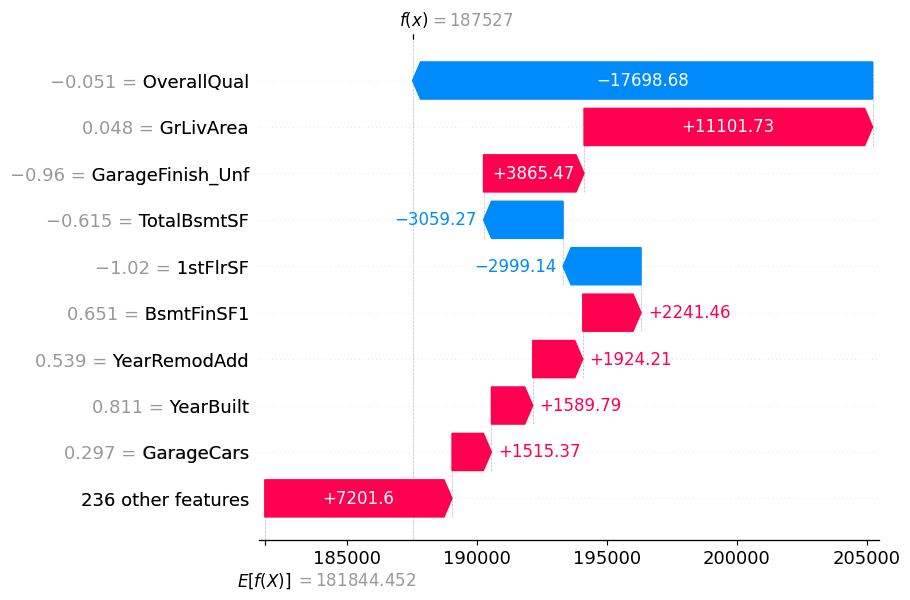

In [45]:
shap.plots.waterfall(shap_values[1])

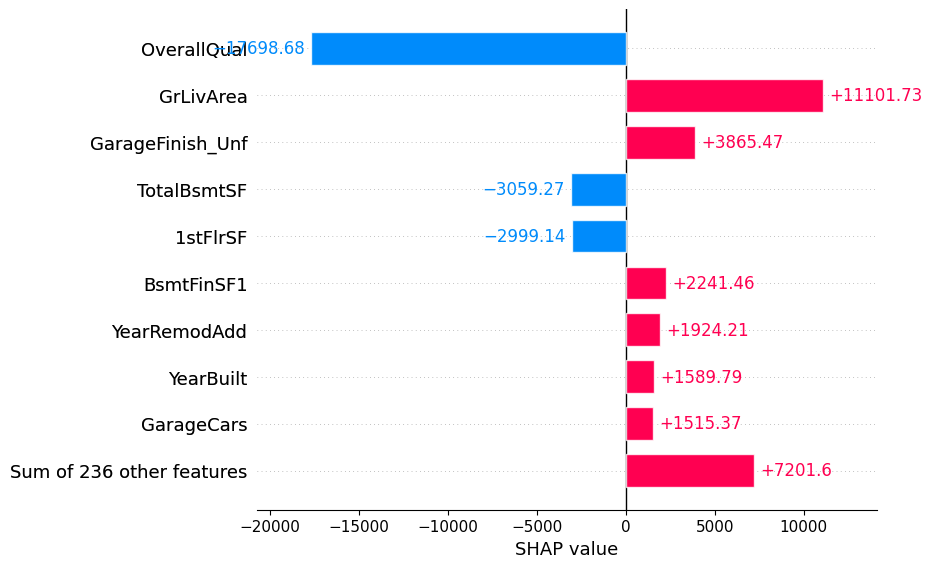

In [46]:
shap.plots.bar(shap_values[1])

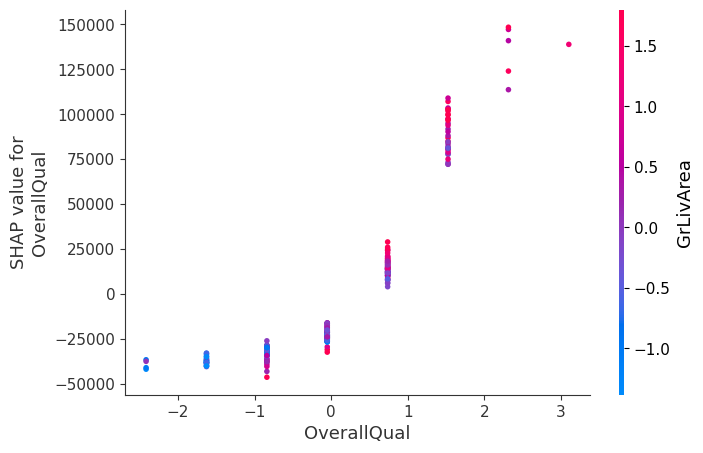

In [47]:
shap.dependence_plot("OverallQual", shap_values.values, X_test_transformed_df,interaction_index="GrLivArea")

In [ ]:
feature_name = "OverallQual"
#feature_shap_values = shap_values[:, X_test.columns.get_loc(feature_name)]

shap.dependence_plot(feature_name, shap_values.values, X_test_transformed_df, interaction_index="YearBuilt", show=True)

In [21]:
def shap_function(model, X_test):
    explainer = shap.Explainer(model) # model ran here is randomforest
    shap_values = explainer(X_test)
    
    shap_values_df = pd.DataFrame(data=shap_values.values, columns=original_column_names)
    return shap_values_df

In [22]:
shap_values_dff = shap_function(model,X_test)
shap_values_dff

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-147.456311,128.513388,-826.350956,-4366.095639,-22574.444081,1468.378008,-3520.379977,1054.334217,-351.270762,-133.929865,...,2.184889,-0.239418,-9.129110,0.698781,-18.975513,0.162285,0.588680,13.863453,85.398247,-36.453514
1,-116.120928,-497.498409,237.656879,-604.912566,9107.183936,-198.763493,1623.278766,699.270371,172.086534,-2679.323457,...,0.075647,-0.050145,-0.090638,0.989934,-35.759995,0.057781,-0.777723,32.654221,109.050022,-21.146958
2,84.025919,177.921333,-84.469521,-549.361554,15614.724009,-89.850425,3783.353519,2783.846915,-600.505289,-2662.819796,...,0.145223,14.952220,247.032546,1.187202,119.830601,0.053749,-0.461286,96.169235,-187.539951,213.630732
3,-327.205976,237.950662,527.586842,2077.354579,76491.460952,-104.870316,1352.303252,344.464695,-471.157343,-5641.022966,...,0.082603,0.230659,-111.569509,0.704320,-107.979162,0.008180,-0.748687,48.967182,-17.623712,-93.623892
4,-109.473003,255.584371,612.840651,-552.241480,-30567.991361,866.638743,1044.748242,-340.244229,-306.345855,-3588.059388,...,0.214863,1.593278,-9.144117,8.124993,-28.869174,-2.743191,-0.044763,22.171924,151.207846,-30.837277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,-62.436228,-109.245787,142.812609,-2668.997497,-40435.416917,-2894.877286,-3215.163708,-1483.771786,-317.249644,-2632.554010,...,0.436639,-0.497256,-6.848336,0.917652,-9.456552,0.159814,-1.580435,14.503149,396.111379,-42.465548
288,-31.671517,228.146201,452.911045,274.084547,-22093.840048,-126.990882,-636.042394,-2646.855452,723.896271,2457.840726,...,0.008630,-0.146653,-12.313721,0.794566,-14.576163,0.033250,-0.366908,60.975504,145.699750,-36.329483
289,356.590898,325.864293,93.694172,-652.867027,17277.913951,-165.644803,1553.466361,1129.690655,-301.434530,-3464.635492,...,0.060024,0.356865,-34.444514,0.722291,-47.646154,0.052318,0.641578,55.668415,-67.037043,-68.709740
290,611.373404,359.961607,118.095139,-1138.921791,18361.018005,-114.120205,2315.132348,1262.369839,361.431783,-2901.656363,...,0.464438,1.083347,-43.036857,0.774508,-52.833954,0.006644,0.126196,57.677334,21.156624,-18.474726


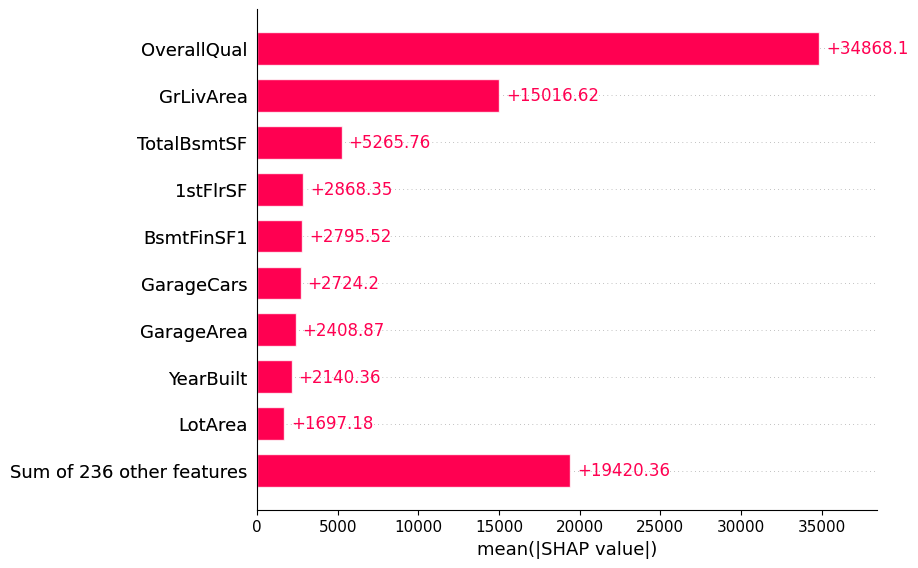

In [14]:
shap.plots.bar(shap_values)

In [19]:
shap.plots.bar(shap_values_df)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

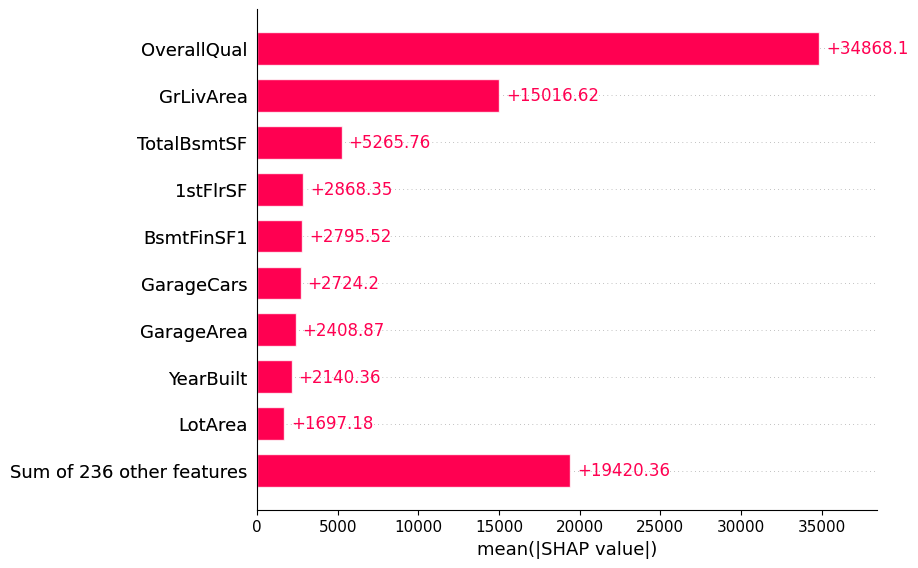

In [17]:
shap.plots.bar(shap_values)